In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
# given the shapes.txt file in the urban folder, print the map of the urban stops
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import os
import pandas as pd
import pymnet as pm
from unidecode import unidecode


In [2]:
BASE_URI_METRO = "GTFS_DATA/True_Metro/"
BASE_URI_URBAN = "GTFS_DATA/True_Urbanos/"
BASE_URI_INTERURBAN = "GTFS_DATA/True_Interurbanos/google_transit_M89/"

In [34]:
metro_nodes = pd.read_csv(os.path.join(BASE_URI_METRO, "_nodes.csv"))
urban_nodes = pd.read_csv(os.path.join(BASE_URI_URBAN, "_nodes.csv"))
interurban_nodes = pd.read_csv(os.path.join(BASE_URI_INTERURBAN, "_nodes.csv"))

metro_edges = pd.read_csv(os.path.join(BASE_URI_METRO, "_edges.csv"))
urban_edges = pd.read_csv(os.path.join(BASE_URI_URBAN, "_edges.csv"))
interurban_edges = pd.read_csv(os.path.join(BASE_URI_INTERURBAN, "_edges.csv"))

In [ ]:
urban_edges_grouped = urban_edges.groupby(["stop_name","next_stop_name"]).count().reset_index()
metro_edges_grouped = metro_edges.groupby(["stop_name","next_stop_name"]).count().reset_index()
interurban_edges_grouped = interurban_edges.groupby(["stop_name","next_stop_name"]).count().reset_index()

In [ ]:
urban_edges_grouped['stop_name'] = urban_edges_grouped['stop_name'].str.upper().apply(lambda x: unidecode(x))
urban_edges_grouped['next_stop_name'] = urban_edges_grouped['next_stop_name'].str.upper().apply(lambda x: unidecode(x))
urban_edges_grouped

metro_edges_grouped['stop_name'] = metro_edges_grouped['stop_name'].str.upper().apply(lambda x: unidecode(x))
metro_edges_grouped['next_stop_name'] = metro_edges_grouped['next_stop_name'].str.upper().apply(lambda x: unidecode(x))
metro_edges_grouped

metro_nodes['stop_name'] = metro_nodes['stop_name'].str.upper().apply(lambda x: unidecode(x))
urban_nodes['stop_name'] = urban_nodes['stop_name'].str.upper().apply(lambda x: unidecode(x))

In [32]:
mnet = pm.MultilayerNetwork(aspects=1)
mnet.add_layer("metro")
mnet.add_layer("urban")
# mnet.add_layer("interurban")
# use names as in caps

for stop_name in metro_nodes['stop_name'].values:
    mnet.add_node(unidecode(stop_name).upper())
for stop_name in urban_nodes['stop_name'].values:
    mnet.add_node(unidecode(stop_name).upper())

for _, row in metro_edges_grouped.iterrows():
    if unidecode(row['stop_name']).upper() != unidecode(row['next_stop_name']).upper():
        mnet[(unidecode(row['stop_name']).upper(), 'metro')][(
            unidecode(row['next_stop_name']).upper(), 'metro')] = 1

for _, row in urban_edges_grouped.iterrows():
    if unidecode(row['stop_name']).upper() != unidecode(row['next_stop_name']).upper():
        mnet[(unidecode(row['stop_name']).upper(), 'urban')][(
            unidecode(row['next_stop_name']).upper(), 'urban')] = 1

# for _, row in interurban_edges_grouped.iterrows():
#     mnet[(row['next_stop_name'], 'interurban')][(row['next_stop_name'], 'interurban')] = 1

for stop_name in metro_edges_grouped['stop_name'].values:
    if stop_name in urban_edges_grouped['stop_name'].values:
        mnet[(stop_name, 'metro')][(stop_name, 'urban')] = 1
        
#     if stop_name in interurban_edges_grouped['stop_name'].values:
#         mnet[(stop_name, 'metro')][(stop_name, 'interurban')] = 1

# for stop_name in urban_edges_grouped['stop_name'].values:
#     if stop_name in interurban_edges_grouped['stop_name'].values:
#         mnet[(stop_name, 'urban')][(stop_name, 'interurban')] = 1



In [40]:
# transform the metro_nodes dataframe to a dictionary with the stop_name as key and the coordinates as value
metro_nodes_dict = metro_nodes.set_index('stop_name')[['stop_lat', 'stop_lon']].T.to_dict('list')
# metro_nodes_dict values as tuples #
metro_nodes_dict = {unidecode(k).upper(): tuple(v) for k, v in metro_nodes_dict.items()}

urban_nodes_dict = urban_nodes.set_index('stop_name')[['stop_lat', 'stop_lon']].T.to_dict('list')
# urban_nodes_dict values as tuples
urban_nodes_dict = {unidecode(k).upper(): tuple(v) for k, v in urban_nodes_dict.items()}

node_coords = {}
node_coords.update({k: v for k, v in urban_nodes_dict.items()})
node_coords.update({k: v for k, v in metro_nodes_dict.items()})

C:\Users\Julio\AppData\Local\Temp\ipykernel_7388\3100619660.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  metro_nodes_dict = metro_nodes.set_index('stop_name')[['stop_lat', 'stop_lon']].T.to_dict('list')
C:\Users\Julio\AppData\Local\Temp\ipykernel_7388\3100619660.py:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  urban_nodes_dict = urban_nodes.set_index('stop_name')[['stop_lat', 'stop_lon']].T.to_dict('list')


In [43]:
node_coords2 = {}
for node, v in metro_nodes_dict.items():
    node_coords2[(node, 'metro')] = v
    node_coords2[(node, 'urban')] = v
for node, v in urban_nodes_dict.items():
    if node_coords2.get((node, 'metro')) is None:
        node_coords2[(node, 'metro')] = v
    node_coords2[(node, 'urban')] = v

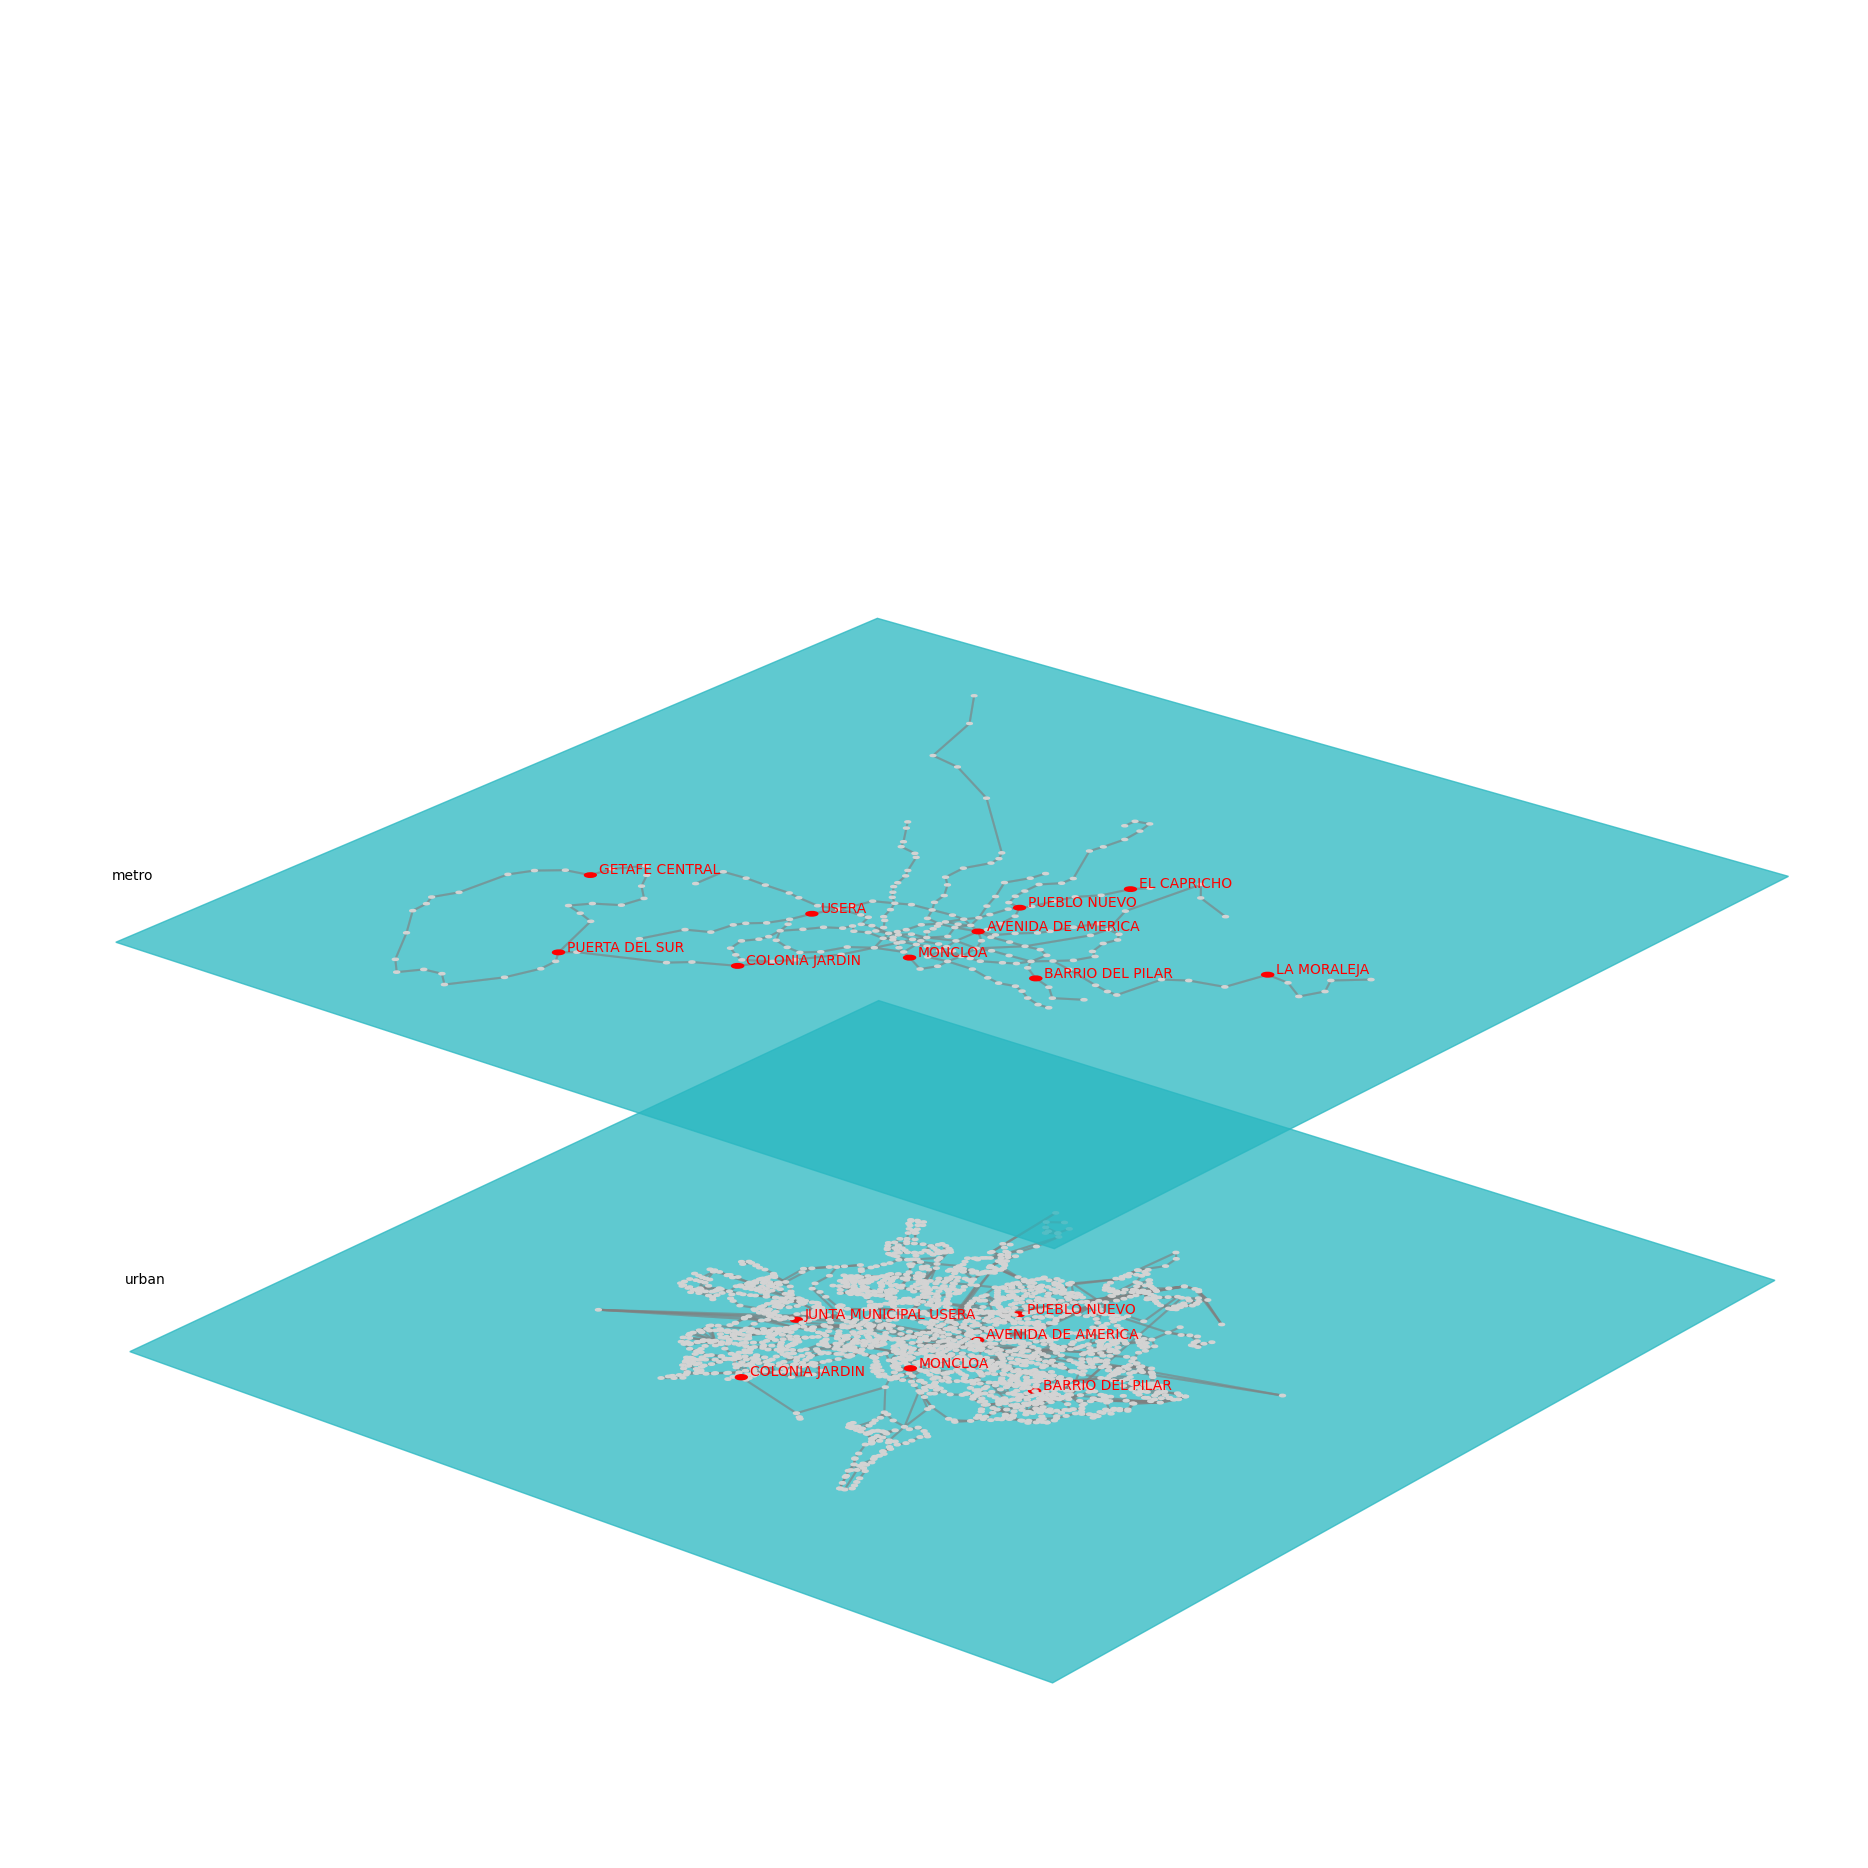

In [46]:
important_nodes = [
    'AVENIDA DE AMERICA',
    'USERA',
    'JUNTA MUNICIPAL USERA',
    'BARRIO DEL PILAR',
    'PUERTA DEL SOL',
    'LA MORALEJA',
    'GETAFE CENTRAL',
    'PUERTA DEL SUR',
    'PUEBLO NUEVO',
    'MONCLOA',
    'EL CAPRICHO',
    'COLONIA JARDIN']


# Custom labels for selected stops
custom_node_labels = {  node:node for node in important_nodes }
# Assign a unique color to each node (using a color palette or named colors)
custom_node_colors = { node: 'red' for node in important_nodes}


nodeAlphaDict = {
    (node, layer): 0.6 if node in custom_node_labels else 0.4
    for (node, layer) in mnet.iter_node_layers()
}
nodeSizeDict = {
    (node, layer): 0.01 if node in custom_node_labels else 0.005
    for (node, layer) in mnet.iter_node_layers()
}
nodeColorDict = {
    (node, layer): 'red' if node in custom_node_labels else 'lightgray'
    for (node, layer) in mnet.iter_node_layers()
}
#for each (node,layer) if layer is metro but node is not in metro_nodes_dict, set the size to 0
for (node, layer) in mnet.iter_node_layers():
    if layer == 'metro' and node not in metro_nodes_dict:
        nodeSizeDict[(node, layer)] = 0.0
for (node, layer) in mnet.iter_node_layers():
    if (layer == 'urban') and node not in urban_nodes_dict:
        nodeSizeDict[(node, layer)] = 0.0

# nodeSizeRuleDict={"rule": "scaled", "scalecoeff": 0.15},
# Build nodeLabelDict and nodeColorDict for all matching node-layer pairs
nodeLabelDict = {
    (node, layer): custom_node_labels[node]
    for (node, layer) in mnet.iter_node_layers()
    if node in custom_node_labels
}


# Draw the multilayer network
fig = plt.figure(figsize=(36, 24))
ax_n = fig.add_subplot(111, projection='3d')
pm.draw(
    mnet,
    nodeLabelDict=nodeLabelDict,       # Show only selected labels
    nodeLabelRule={},                  # No automatic labels
    nodeCoords=node_coords,            # Use shapefile-coordinates
    defaultNodeLabel="",               # Hide others
    defaultLayerLabelLoc=(-0.1, 0.1),  # Position layer names
    defaultEdgeAlpha=0.4,              # Edge transparency
    defaultNodeLabelAlpha=1,
    defaultNodeLabelColor='red',
    defaultNodeColor='lightgray',  # Default node color
    nodeColorDict=nodeColorDict,       # Custom node colors
    nodeSizeDict=nodeSizeDict,         # Custom node sizes
    layergap=1,                        # Layer vertical separation
    ax=ax_n
)

fig.savefig('full_madrid_transport_network.png', bbox_inches='tight')


In [45]:
for (node,layer) in mnet.iter_node_layers():
    print(f"Node: {node}, Layer: {layer}, Coords: {node_coords2[(node, layer)]}")

Node: CORREGIDOR ALONSO AGUILAR, Layer: urban, Coords: (40.4072277365642, -3.65786947696784)
Node: CORREGIDOR ALONSO AGUILAR, Layer: metro, Coords: (40.4072277365642, -3.65786947696784)
Node: JOSEFA VALCARCEL-GENERAL ARANAZ, Layer: urban, Coords: (40.448542022076, -3.64768659667256)
Node: JOSEFA VALCARCEL-GENERAL ARANAZ, Layer: metro, Coords: (40.448542022076, -3.64768659667256)
Node: CAMINO VIEJO LEGANES-CARRERO JUAN RAMON, Layer: urban, Coords: (40.3805233548584, -3.73170312137737)
Node: CAMINO VIEJO LEGANES-CARRERO JUAN RAMON, Layer: metro, Coords: (40.3805233548584, -3.73170312137737)
Node: RONDA COMUNICACION-EDIFICIO OESTE 2, Layer: urban, Coords: (40.5151674949954, -3.66599150830128)
Node: RONDA COMUNICACION-EDIFICIO OESTE 2, Layer: metro, Coords: (40.5151674949954, -3.66599150830128)
Node: ESTAFETA-AVENIDA SAN FERMIN, Layer: urban, Coords: (40.3715999079195, -3.69211744819208)
Node: ESTAFETA-AVENIDA SAN FERMIN, Layer: metro, Coords: (40.3715999079195, -3.69211744819208)
Node: PA

In [31]:
node_coords

{('PUERTA DE ALCALA', 'urban'): (40.4205812410254, -3.68850871995585),
 ('PUERTA DE ALCALA-RETIRO', 'urban'): (40.4196998317684, -3.68826031065316),
 ('CIRCULO DE BELLAS ARTES', 'urban'): (40.418671117781, -3.69607829125748),
 ('SANTO DOMINGO', 'urban'): (40.4221807674038, -3.70786357146234),
 ('GRAN VIA-PLAZA DE ESPANA', 'urban'): (40.4227400039474, -3.70996037530691),
 ('VENTURA RODRIGUEZ', 'urban'): (40.4260628731286, -3.71313036134631),
 ('PLAZA DE ESPANA', 'urban'): (40.4228006375783, -3.71182356650827),
 ('PRINCESA-REY FRANCISCO', 'urban'): (40.4283432151913, -3.71441991219973),
 ('PLAZA SAN CAYETANO', 'urban'): (40.4340019985026, -3.67054504133793),
 ('PROSPERIDAD', 'urban'): (40.4447137945685, -3.67363617563718),
 ('MONCLOA', 'urban'): (40.435858095584, -3.7192925584778),
 ('JUNTA MUNICIPAL MONCLOA', 'urban'): (40.4358409821157, -3.71842134613126),
 ('GRAN VIA-MONTERA', 'urban'): (40.4200013000184, -3.70108154783931),
 ('VELAZQUEZ-VILLANUEVA', 'urban'): (40.4222103360285, -3.68

In [89]:
# count number of nodes in each layer
metro_nodes_count = len(metro_nodes_dict)
urban_nodes_count = len(urban_nodes_dict)

# count number of edges in each layer
metro_edges_count = len(metro_edges_grouped)
urban_edges_count = len(urban_edges_grouped)


In [90]:
print(f"Metro nodes count: {metro_nodes_count}")
print(f"Urban nodes count: {urban_nodes_count}")
print(f"Metro edges count: {metro_edges_count}")
print(f"Urban edges count: {urban_edges_count}")


Metro nodes count: 242
Urban nodes count: 2557
Metro edges count: 552
Urban edges count: 5588


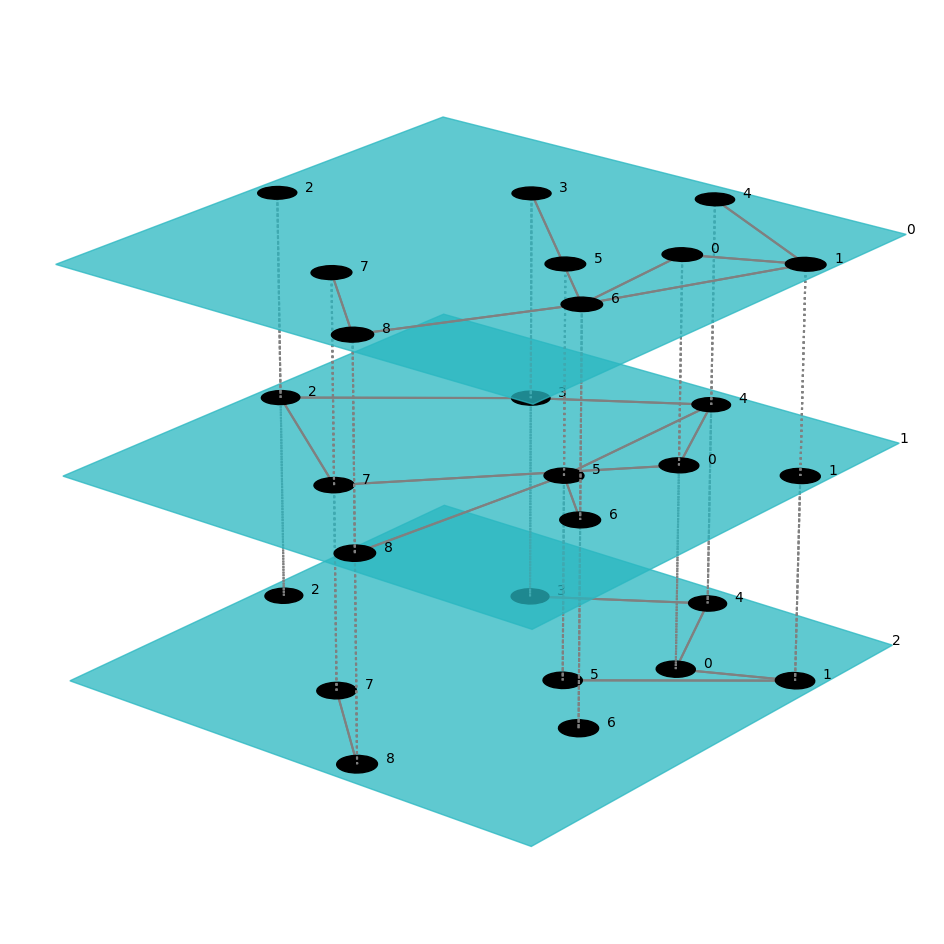

In [68]:
er = pm.models.er(9,[0.3,0.2,0.1])


fig = plt.figure(figsize=(24, 12))
ax_n = fig.add_subplot(111, projection='3d')
pm.draw(
    er,
    ax=ax_n
)

fig.savefig('draw_funct.png', dpi=300, bbox_inches='tight')